In [2]:
import os
from scipy.ndimage import rotate, zoom
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import hashlib
%pip install tensorflow
import tensorflow as tf
import time
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from IPython.display import display, Markdown as md
from tensorflow.keras import layers, models, utils
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNetV2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/645.0 MB ? eta -:--:--Downloading tensorflow-2.19.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (645.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 12.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/5.9 MB ? eta -:--:--Downloading grpcio-1.71.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (5.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/4.9 MB ? eta -:--:--Downloading h5py-3.13.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

2025-04-26 06:01:04.602265: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 06:01:04.961695: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-26 06:01:05.061458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745647265.176332   13240 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745647265.228947   13240 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745647266.317978   13240 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
# Define the base path for the dataset locally
path = '/workspaces/AtlanticoAvanti/data'
dataset_path = Path(path)

# Definição dos caminhos das pastas de treino e teste dentro do dataset
pasta_treinamento = os.path.join(path, "train")  # Caminho para a pasta de treino
pasta_teste = os.path.join(path, "test")    # Caminho para a pasta de teste

# Definir os caminhos para as subpastas de imagens e máscaras
pasta_img_treino = os.path.join(pasta_treinamento, "image")
pasta_mask_treino = os.path.join(pasta_treinamento, "mask")
pasta_img_teste = os.path.join(pasta_teste, "image")
pasta_mask_teste = os.path.join(pasta_teste, "mask")

# Verificar se os caminhos existem
print(f"Verificando caminho base do dataset: {path} (Existe: {os.path.exists(path)})")
print(f"Verificando pasta de treinamento: {pasta_treinamento} (Existe: {os.path.exists(pasta_treinamento)})")
print(f"Verificando pasta de teste: {pasta_teste} (Existe: {os.path.exists(pasta_teste)})")
print("\nVerificando subpastas:")
print(f"Imagens de treino: {pasta_img_treino} (Existe: {os.path.exists(pasta_img_treino)})")
print(f"Máscaras de treino: {pasta_mask_treino} (Existe: {os.path.exists(pasta_mask_treino)})")
print(f"Imagens de teste: {pasta_img_teste} (Existe: {os.path.exists(pasta_img_teste)})")
print(f"Máscaras de teste: {pasta_mask_teste} (Existe: {os.path.exists(pasta_mask_teste)})")

Verificando caminho base do dataset: /workspaces/AtlanticoAvanti/data (Existe: True)
Verificando pasta de treinamento: /workspaces/AtlanticoAvanti/data/train (Existe: True)
Verificando pasta de teste: /workspaces/AtlanticoAvanti/data/test (Existe: True)

Verificando subpastas:
Imagens de treino: /workspaces/AtlanticoAvanti/data/train/image (Existe: True)
Máscaras de treino: /workspaces/AtlanticoAvanti/data/train/mask (Existe: True)
Imagens de teste: /workspaces/AtlanticoAvanti/data/test/image (Existe: True)
Máscaras de teste: /workspaces/AtlanticoAvanti/data/test/mask (Existe: True)


In [4]:
imagens_info = []
for pasta_raiz, subpastas, arquivos in os.walk(path): #percorrendo diretorios e subdiretorios dentro do caminho em path
  for arquivo in arquivos: #percorre a lista de arquivos dentro da pasta atual
    if arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')): #se os arquivos tiverem essas extensões
      caminho_completo = os.path.join(pasta_raiz, arquivo) # cria o caminho absoluto do arquivo, unindo a pasta onde ele está com seu nome.
      categoria = os.path.basename(pasta_raiz) #retorna apenas o nome da última pasta no caminho. (ex: "C:/Users/Hanna/Imagens/Dataset/Gatos")
      #ele vai me retornar GATOS
      with Image.open(caminho_completo) as img:
                largura, altura = img.size  # Dimensões
                num_pixels = largura * altura  # Total de pixels
                modo = img.mode  # Modo da imagem (RGB, Grayscale etc.)
      imagens_info.append({
          'arquivo' : arquivo, #nome do arquivo da imagem
          'caminho' : caminho_completo, #caminho do arquivo
          'categoria' : categoria, #nome da pasta onde está a imagem
          'largura': largura, #adicionei para printar as dimensões depois
          'altura': altura, #adicionei para printar as dimensões depois
          'num_pixels': num_pixels, #adicionei para printar as dimensões depois
          'modo' : modo #modo L indica que a imagem tem 8bits por pixel, 256 níves de cinza (variando de 0 preto a 255 branco)
          }) #dicionario criado com tres infos: nomedoarquivo / caminho do arquivo / e qual categoria da imagem (mask)

df_imagens = pd.DataFrame(imagens_info) #converte a lista de dicionários em um dataframe do pandas

print(f"Total de imagens: {len(df_imagens)}") #total de imagens = 200

Total de imagens: 200


In [5]:
# Verificação se todas as imagens estão no mesmo formato
# Lista para armazenar os formatos das imagens
formatos_imagens = set()

# Usar o dataset_path definido na célula anterior
# dataset_path = Path(path) # Redundant if path is correctly set before

# Percorrer todos os arquivos do diretório
print(f"Verificando formatos de imagens em: {path}")

# Procurar arquivos de imagem nas pastas definidas
for pasta in [pasta_img_treino, pasta_mask_treino, pasta_img_teste, pasta_mask_teste]:
    if os.path.exists(pasta):
        print(f"Verificando pasta: {pasta}")
        for arquivo in os.listdir(pasta):
            if arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                caminho_completo = os.path.join(pasta, arquivo)
                try:
                    with Image.open(caminho_completo) as img:
                        formatos_imagens.add(img.format)
                except Exception as e:
                    print(f"Erro ao processar {caminho_completo}: {e}")
    else:
        print(f"Aviso: Pasta não encontrada - {pasta}")

# Exibe os formatos encontrados
print("\nFormatos de imagem encontrados:", formatos_imagens)

# Verifica se todas as imagens têm o mesmo formato
if not formatos_imagens:
    print("Nenhuma imagem encontrada para verificar formatos.")
elif len(formatos_imagens) == 1:
    print(f"Todas as imagens encontradas estão no formato {list(formatos_imagens)[0]}.")
else:
    print("As imagens possuem formatos diferentes.")

Verificando formatos de imagens em: /workspaces/AtlanticoAvanti/data
Verificando pasta: /workspaces/AtlanticoAvanti/data/train/image
Verificando pasta: /workspaces/AtlanticoAvanti/data/train/mask
Verificando pasta: /workspaces/AtlanticoAvanti/data/test/image
Verificando pasta: /workspaces/AtlanticoAvanti/data/test/mask

Formatos de imagem encontrados: {'PNG'}
Todas as imagens encontradas estão no formato PNG.


In [6]:
if df_imagens[['largura', 'altura']].nunique().sum() == 2: #nunique() conta quantos valores diferentes existem nas colunas largura e altura
    print("Todas as imagens têm o mesmo tamanho.")
else:
    print("As imagens têm tamanhos diferentes.")

Todas as imagens têm o mesmo tamanho.


In [7]:
# Agrupa as imagens por categoria (pasta) e lista os modos de cor encontrados em cada uma
modos_por_categoria = df_imagens.groupby('categoria')['modo'].unique()

# Exibe os modos de cor encontrados para cada categoria
for categoria, modos in modos_por_categoria.items():
    print(f"Na pasta '{categoria}', encontramos os modos de cor: {modos}")

# Cria um dicionário para armazenar inconsistências
# Se uma categoria tiver mais de um modo de cor, será considerada inconsistente
inconsistencias = {cat: modos for cat, modos in modos_por_categoria.items() if len(modos) > 1}

# Verifica se foram encontradas inconsistências
if inconsistencias:
    print("\nAtenção! Algumas categorias possuem imagens com diferentes modos de cor:")
    for cat, modos in inconsistencias.items():
        print(f"- {cat}: {modos}")  # Exibe a categoria e os modos de cor encontrados nela
else:
    print("\nTodas as categorias possuem um único modo de cor. Nenhuma inconsistência encontrada.")


Na pasta 'image', encontramos os modos de cor: ['RGB']
Na pasta 'mask', encontramos os modos de cor: ['L']

Todas as categorias possuem um único modo de cor. Nenhuma inconsistência encontrada.


In [8]:
def sumario_coluna(df):

    dados_resumo = []

    for nome_coluna in df.columns:
        tipo_coluna = df[nome_coluna].dtype
        valores_distintos = df[nome_coluna].nunique()

        contagem_distintos = None
        if valores_distintos <= 10:
            contagem_distintos = df[nome_coluna].value_counts().to_dict()

        dados_resumo.append([
            nome_coluna,
            str(tipo_coluna),
            valores_distintos,
            contagem_distintos
        ])

    # Markdown para exibição
    saida_markdown = "## 📊 Sumário das Colunas\n\n"
    saida_markdown += "| Coluna | Tipo de Dado | Valores Distintos | Distribuição dos Valores |\n"
    saida_markdown += "|--------|---------------|-------------------|--------------------------|\n"

    for col in dados_resumo:
        distribuicao = col[3] if col[3] is not None else "N/A"
        saida_markdown += f"| `{col[0]}` | `{col[1]}` | {col[2]} | {distribuicao} |\n"

    display(md(saida_markdown))

# Exemplo de uso
sumario_coluna(df_imagens)

## 📊 Sumário das Colunas

| Coluna | Tipo de Dado | Valores Distintos | Distribuição dos Valores |
|--------|---------------|-------------------|--------------------------|
| `arquivo` | `object` | 80 | N/A |
| `caminho` | `object` | 200 | N/A |
| `categoria` | `object` | 2 | {'image': 100, 'mask': 100} |
| `largura` | `int64` | 1 | {512: 200} |
| `altura` | `int64` | 1 | {512: 200} |
| `num_pixels` | `int64` | 1 | {262144: 200} |
| `modo` | `object` | 2 | {'RGB': 100, 'L': 100} |


* Visualizando algumas imagens do dataset

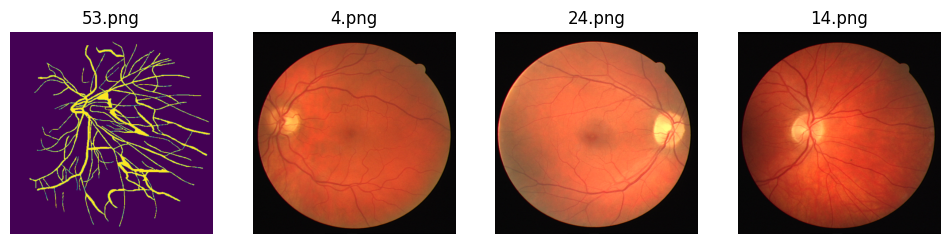

In [9]:
amostras = df_imagens.sample(4)  # visualizando 4 imagens do dataframe

fig, axes = plt.subplots(1, 4, figsize=(12, 6)) #plotando as imagens
for ax, (_, row) in zip(axes, amostras.iterrows()):
    img = Image.open(row["caminho"])  # Abre a imagem
    ax.imshow(img)
    ax.set_title(row["arquivo"])
    ax.axis("off")  # Remove os eixos

plt.show()

Informações complementares, tamanho, pixel e dimensões da figura

In [10]:
print(df_imagens[['largura', 'altura', 'num_pixels']].describe()) #não há variação nas imagens

       largura  altura  num_pixels
count    200.0   200.0       200.0
mean     512.0   512.0    262144.0
std        0.0     0.0         0.0
min      512.0   512.0    262144.0
25%      512.0   512.0    262144.0
50%      512.0   512.0    262144.0
75%      512.0   512.0    262144.0
max      512.0   512.0    262144.0


* Verificando se há imagens corrompidas que não podem abertas ou processadas

In [11]:
def verificar_imagens_corrompidas(caminho_pasta):
    imagens_corrompidas = []

    for raiz, _, arquivos in os.walk(caminho_pasta):  # Percorre recursivamente o diretório do dataset
        for arquivo in arquivos:
            caminho_arquivo = os.path.join(raiz, arquivo)
            try:
                with Image.open(caminho_arquivo) as imagem:  # Tenta abrir cada imagem
                    imagem.verify()  # Verifica a integridade da imagem
            except (IOError, SyntaxError) as erro:  # Se ocorrer um erro, a imagem é considerada corrompida
                print(f"Imagem corrompida encontrada: {caminho_arquivo} - Erro: {erro}")
                imagens_corrompidas.append(caminho_arquivo)

    return imagens_corrompidas

# Executa a verificação e exibe o número de imagens corrompidas
imagens_corrompidas = verificar_imagens_corrompidas(path)
print(f"Número de imagens corrompidas: {len(imagens_corrompidas)}")

Número de imagens corrompidas: 0


Distribuição das classes no conjunto de treino: {'image': 80, 'mask': 80}
Distribuição das classes no conjunto de teste: {'image': 20, 'mask': 20}


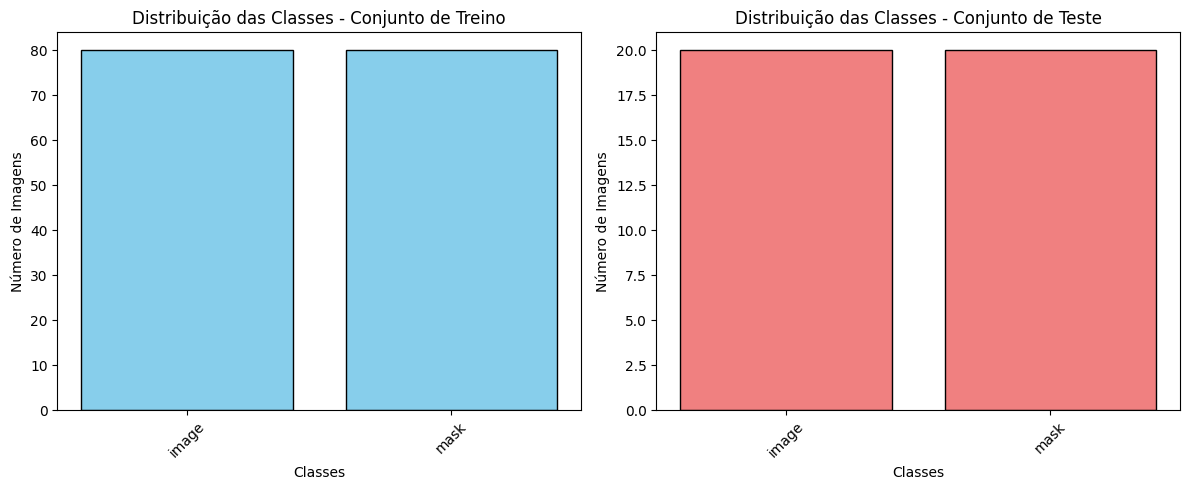

In [12]:
# Função para contar o número de imagens por classe
def contar_imagens_por_classe(caminho_pasta):

    if not os.path.exists(caminho_pasta):  # Verifica se o diretório existe
        print(f"A pasta '{caminho_pasta}' não foi encontrada.")  # Exibe um aviso caso a pasta não exista
        return {}  # Retorna um dicionário vazio

    # Cria um dicionário onde cada chave é uma classe (nome da pasta) e o valor é a quantidade de imagens
    contagem_por_classe = {
        classe: len(os.listdir(os.path.join(caminho_pasta, classe)))
        for classe in os.listdir(caminho_pasta)
        if os.path.isdir(os.path.join(caminho_pasta, classe))  # Considera apenas diretórios
    }

    return contagem_por_classe  # Retorna o dicionário com as contagens

def plotar_distribuicao_classes(contagem_treino, contagem_teste):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Cria uma figura com 2 gráficos lado a lado

    # Gráfico para o conjunto de treino
    axes[0].bar(contagem_treino.keys(), contagem_treino.values(), color='skyblue', edgecolor='black')  # Cria gráfico de barras
    axes[0].set_title("Distribuição das Classes - Conjunto de Treino")  # Define o título do gráfico
    axes[0].set_xlabel("Classes")  # Nomeia o eixo X
    axes[0].set_ylabel("Número de Imagens")  # Nomeia o eixo Y
    axes[0].tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo X para melhor leitura

    # Gráfico para o conjunto de teste
    axes[1].bar(contagem_teste.keys(), contagem_teste.values(), color='lightcoral', edgecolor='black')  # Cria gráfico de barras
    axes[1].set_title("Distribuição das Classes - Conjunto de Teste")  # Define o título do gráfico
    axes[1].set_xlabel("Classes")  # Nomeia o eixo X
    axes[1].set_ylabel("Número de Imagens")  # Nomeia o eixo Y
    axes[1].tick_params(axis='x', rotation=45)  # Rotaciona os rótulos do eixo X para melhor leitura

    plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos
    plt.show()  # Exibe os gráficos

def main():
    # Contagem das imagens por classe em cada conjunto (treino e teste)
    contagem_treino = contar_imagens_por_classe(pasta_treinamento)
    contagem_teste = contar_imagens_por_classe(pasta_teste)

    if not contagem_treino or not contagem_teste:  # Se não houver imagens em um dos conjuntos
        print("Não foi possível encontrar dados suficientes para análise.")  # Exibe um aviso
        return  # Encerra a execução

    # Exibir contagem das classes no terminal
    print("Distribuição das classes no conjunto de treino:", contagem_treino)
    print("Distribuição das classes no conjunto de teste:", contagem_teste)

    # Gerar os gráficos de distribuição das classes
    plotar_distribuicao_classes(contagem_treino, contagem_teste)


# Garante que o script só será executado se for chamado diretamente (evita execução acidental ao importar como módulo)
if __name__ == "__main__":
    main()

* Conferindo imagens duplicadas que possam enviesar os resultados.
  * Para detectar imagens duplicadas no dataset (mesmo que tenham nomes diferentes), podemos comparar os arquivos pelo hash (assinatura digital) de cada imagem. Isso garante que duas imagens idênticas serão detectadas mesmo que tenham nomes diferentes.

In [13]:
# Importar o módulo defaultdict se ainda não foi importado
from collections import defaultdict

# Função para calcular o hash de uma imagem
def calcular_hash(imagem_path):
    try:
        with Image.open(imagem_path) as img:  # Abre a imagem usando a biblioteca PIL (Pillow)
            img = img.convert("L")  # Converte para escala de cinza para reduzir variações de cor
            return hashlib.md5(img.tobytes()).hexdigest()  # Gera um hash MD5 com os bytes da imagem
    except Exception as e:
        print(f"Erro ao calcular hash para {imagem_path}: {e}")
        return None

# Função para encontrar duplicatas dentro de uma pasta
def encontrar_duplicatas(pasta):
    hashes = defaultdict(list)  # Dicionário onde a chave é o hash e o valor é uma lista de arquivos
    
    # Verificar se a pasta existe
    if not os.path.exists(pasta):
        print(f"Pasta não encontrada: {pasta}")
        return {}
        
    # Percorre todos os arquivos na pasta
    print(f"Verificando duplicatas em: {pasta}")
    for arquivo in tqdm(os.listdir(pasta)):
        caminho_completo = os.path.join(pasta, arquivo)  # Obtém o caminho completo do arquivo
        if arquivo.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            hash_imagem = calcular_hash(caminho_completo)  # Calcula o hash da imagem
            if hash_imagem:
                hashes[hash_imagem].append(caminho_completo)  # Adiciona o arquivo à lista de imagens com esse hash

    # Dicionário para armazenar apenas os hashes que possuem mais de uma imagem associada
    duplicatas = {}

    # Percorre todos os hashes e suas respectivas listas de arquivos
    for hash_valor, arquivos in hashes.items():
        if len(arquivos) > 1:
            duplicatas[hash_valor] = arquivos

    return duplicatas  # Retorna um dicionário com os arquivos duplicados

# Usar os caminhos definidos anteriormente
pastas_imagem = [pasta_img_treino, pasta_img_teste]
pastas_mask = [pasta_mask_treino, pasta_mask_teste]

# Verificar duplicatas nas imagens
display(md("\n🔍 **Duplicatas em imagens:**"))
total_duplicatas_img = 0
for pasta in pastas_imagem:
    duplicatas = encontrar_duplicatas(pasta)
    if duplicatas:
        total_duplicatas_img += sum(len(files) for files in duplicatas.values())
        display(md(f"Duplicatas encontradas em {pasta}:"))
        for h, arquivos in duplicatas.items():
            display(md(f"  - Hash: {h}"))
            for arq in arquivos:
                display(md(f"    * {arq}"))
    else:
        display(md(f"Nenhuma duplicata encontrada em {pasta}"))
if total_duplicatas_img == 0:
    display(md("Nenhuma imagem duplicada encontrada no total."))

# Verificar duplicatas nas máscaras
display(md("\n🔍 **Duplicatas em máscaras:**"))
total_duplicatas_mask = 0
for pasta in pastas_mask:
    duplicatas = encontrar_duplicatas(pasta)
    if duplicatas:
        total_duplicatas_mask += sum(len(files) for files in duplicatas.values())
        display(md(f"Duplicatas encontradas em {pasta}:"))
        for h, arquivos in duplicatas.items():
            display(md(f"  - Hash: {h}"))
            for arq in arquivos:
                display(md(f"    * {arq}"))
    else:
        display(md(f"Nenhuma duplicata encontrada em {pasta}"))
if total_duplicatas_mask == 0:
    display(md("Nenhuma máscara duplicada encontrada no total."))


🔍 **Duplicatas em imagens:**

Verificando duplicatas em: /workspaces/AtlanticoAvanti/data/train/image


100%|██████████| 80/80 [00:00<00:00, 168.18it/s]


Nenhuma duplicata encontrada em /workspaces/AtlanticoAvanti/data/train/image

Verificando duplicatas em: /workspaces/AtlanticoAvanti/data/test/image


100%|██████████| 20/20 [00:00<00:00, 162.62it/s]


Nenhuma duplicata encontrada em /workspaces/AtlanticoAvanti/data/test/image

Nenhuma imagem duplicada encontrada no total.


🔍 **Duplicatas em máscaras:**

Verificando duplicatas em: /workspaces/AtlanticoAvanti/data/train/mask


100%|██████████| 80/80 [00:00<00:00, 517.99it/s]


Nenhuma duplicata encontrada em /workspaces/AtlanticoAvanti/data/train/mask

Verificando duplicatas em: /workspaces/AtlanticoAvanti/data/test/mask


100%|██████████| 20/20 [00:00<00:00, 490.94it/s]


Nenhuma duplicata encontrada em /workspaces/AtlanticoAvanti/data/test/mask

Nenhuma máscara duplicada encontrada no total.


Carregando dados de treinamento...
Carregando dados de: /workspaces/AtlanticoAvanti/data/train/image e /workspaces/AtlanticoAvanti/data/train/mask
Encontrados 80 imagens e 80 máscaras para processar.


100%|██████████| 80/80 [00:00<00:00, 97.49it/s]
2025-04-26 06:01:51.715029: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)

2025-04-26 06:01:51.715029: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Dados de treinamento carregados: (80, 128, 128, 3), (80, 128, 128, 1)
Dataset de treinamento criado com sucesso!

Carregando dados de teste...
Carregando dados de: /workspaces/AtlanticoAvanti/data/test/image e /workspaces/AtlanticoAvanti/data/test/mask
Encontrados 20 imagens e 20 máscaras para processar.


100%|██████████| 20/20 [00:00<00:00, 105.22it/s]

2025-04-26 06:01:52.095847: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-26 06:01:52.095847: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Dados de teste carregados: (20, 128, 128, 3), (20, 128, 128, 1)
Dataset de teste criado com sucesso!

Visualizando amostras do dataset de TREINO para verificar o pré-processamento:


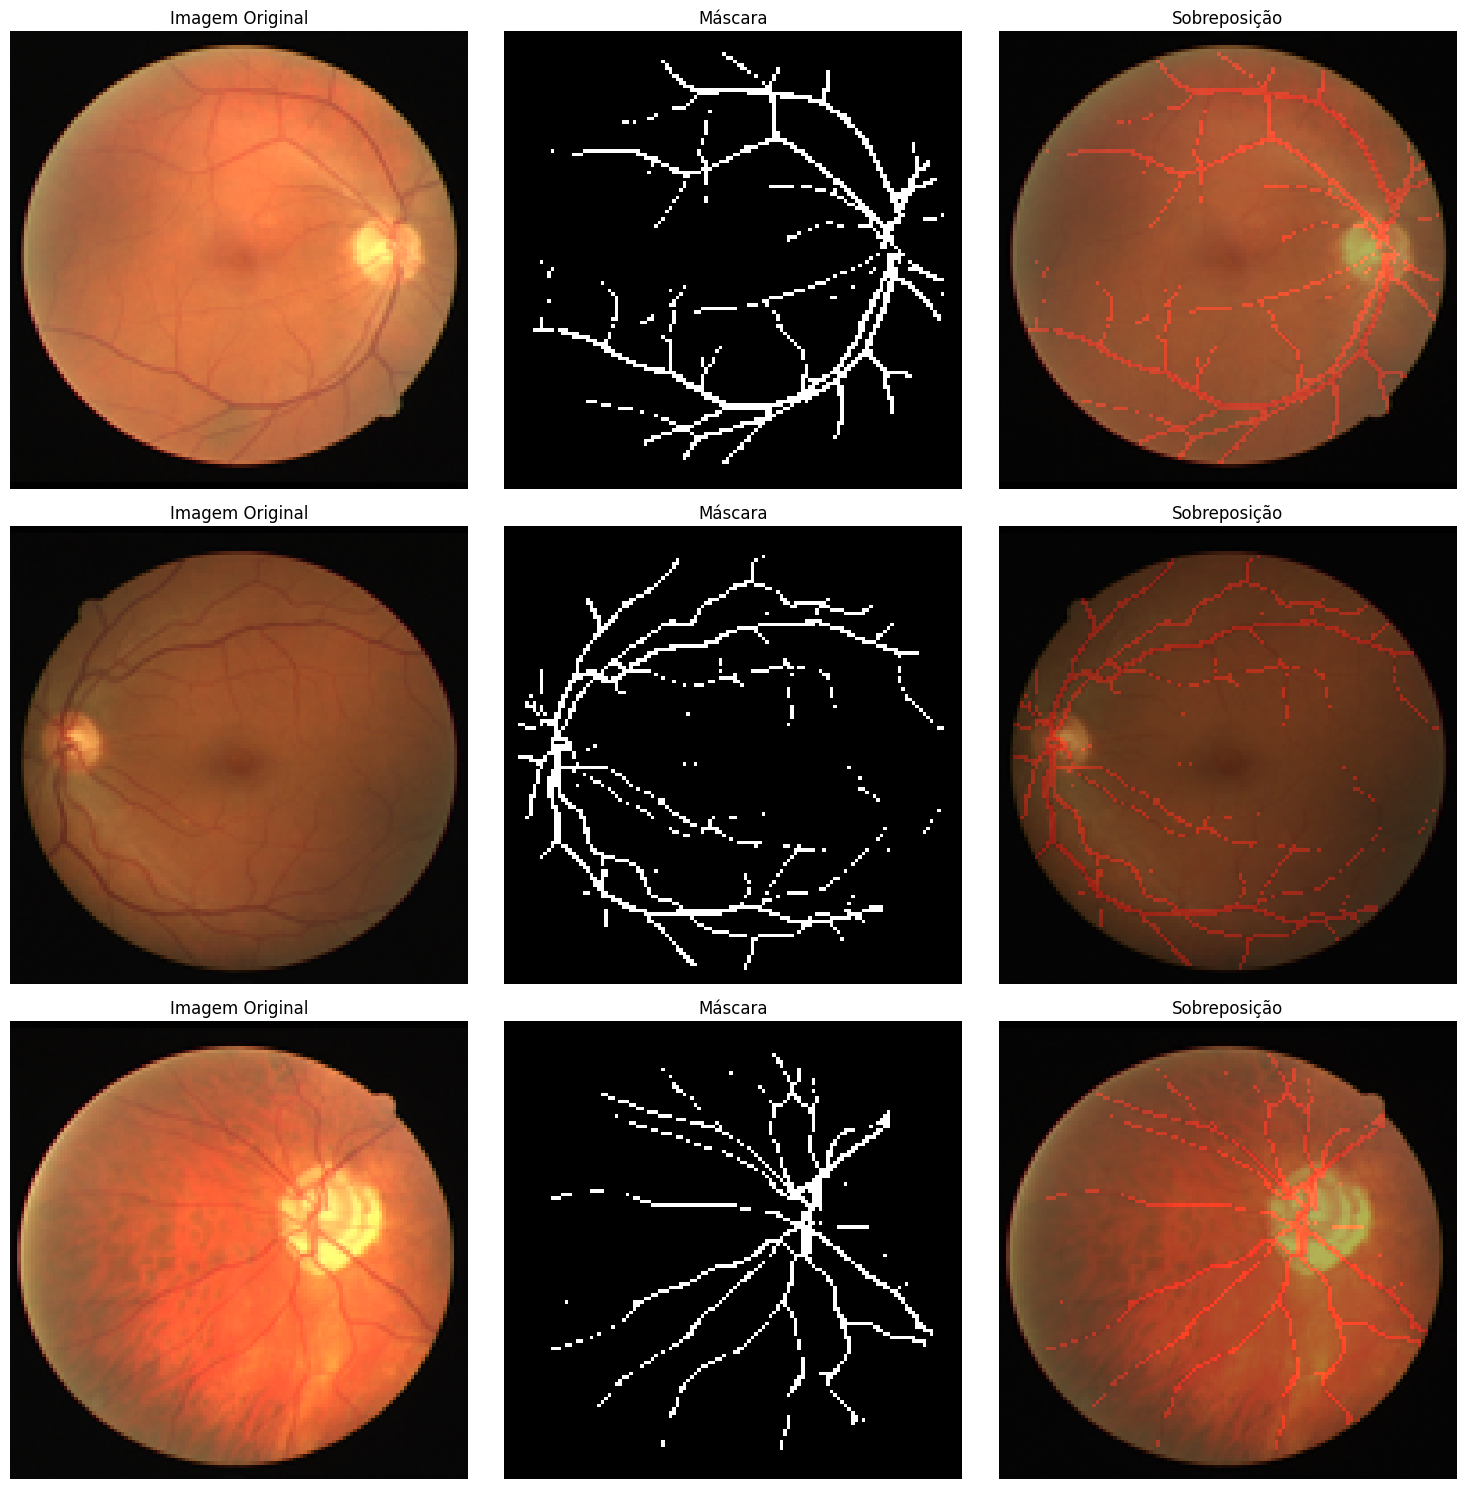

Pré-processamento e criação de datasets concluídos.


In [14]:
# Função de pré-processamento para carregar e redimensionar as imagens
def carregar_e_preprocessar_dados(pasta_imagem, pasta_mascara, tamanho_alvo=(128, 128)):
    # Verificar se as pastas existem
    if not os.path.exists(pasta_imagem):
        raise FileNotFoundError(f"Pasta de imagens não encontrada: {pasta_imagem}")
    if not os.path.exists(pasta_mascara):
        raise FileNotFoundError(f"Pasta de máscaras não encontrada: {pasta_mascara}")

    print(f"Carregando dados de: {pasta_imagem} e {pasta_mascara}")
    imagens = []
    mascaras = []

    # Listar os arquivos nas pastas
    arquivos_imagem = sorted([f for f in os.listdir(pasta_imagem)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])
    arquivos_mascara = sorted([f for f in os.listdir(pasta_mascara)
                             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))])

    # Garantir que os nomes dos arquivos (sem extensão) correspondem
    nomes_imagem = {os.path.splitext(f)[0] for f in arquivos_imagem}
    nomes_mascara = {os.path.splitext(f)[0] for f in arquivos_mascara}

    if nomes_imagem != nomes_mascara:
        print("Aviso: Nomes de arquivos de imagem e máscara não correspondem perfeitamente!")
        print(f"Imagens extras: {nomes_imagem - nomes_mascara}")
        print(f"Máscaras extras: {nomes_mascara - nomes_imagem}")
        # Continuar apenas com os arquivos que têm par
        arquivos_comuns = nomes_imagem.intersection(nomes_mascara)
        arquivos_imagem = sorted([f for f in arquivos_imagem if os.path.splitext(f)[0] in arquivos_comuns])
        arquivos_mascara = sorted([f for f in arquivos_mascara if os.path.splitext(f)[0] in arquivos_comuns])
        print(f"Processando {len(arquivos_comuns)} pares de arquivos correspondentes.")

    print(f"Encontrados {len(arquivos_imagem)} imagens e {len(arquivos_mascara)} máscaras para processar.")

    # Processar cada par de imagem e máscara
    for arquivo_img, arquivo_mask in tqdm(zip(arquivos_imagem, arquivos_mascara), total=len(arquivos_imagem)):
        try:
            # Carregar imagem e redimensionar
            caminho_imagem = os.path.join(pasta_imagem, arquivo_img)
            img = Image.open(caminho_imagem)
            img = img.resize(tamanho_alvo)
            img_array = np.array(img)

            # Garantir 3 canais (RGB)
            if len(img_array.shape) == 2:
                img_array = np.stack((img_array,) * 3, axis=-1)
            elif img_array.shape[2] == 4: # Remover canal alfa se existir
                 img_array = img_array[:, :, :3]

            # Carregar máscara e redimensionar
            caminho_mascara = os.path.join(pasta_mascara, arquivo_mask)
            mask = Image.open(caminho_mascara)
            mask = mask.resize(tamanho_alvo)
            mask_array = np.array(mask)

            # Converter máscara para binário (0 ou 1)
            if len(mask_array.shape) == 3 and mask_array.shape[2] > 1:
                mask_array = np.mean(mask_array, axis=2)
            mask_array = (mask_array > 128).astype(np.float32)

            # Adicionar dimensão de canal se necessário
            if len(mask_array.shape) == 2:
                mask_array = np.expand_dims(mask_array, axis=-1)

            # Normalizar imagem (dividir por 255 para escalar entre 0-1)
            img_array = img_array.astype(np.float32) / 255.0

            # Adicionar aos arrays
            imagens.append(img_array)
            mascaras.append(mask_array)
        except Exception as e:
            print(f"Erro ao processar par {arquivo_img}/{arquivo_mask}: {e}")

    return np.array(imagens), np.array(mascaras)

# Criar datasets do TensorFlow para treinamento e teste
def criar_tf_dataset(imagens, mascaras, tamanho_batch=32, shuffle=True):
    if len(imagens) == 0:
        print("Erro: Não há imagens para criar o dataset.")
        return None
    dataset = tf.data.Dataset.from_tensor_slices((imagens, mascaras))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(imagens))
    dataset = dataset.batch(tamanho_batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Removido: Função encontrar_pastas_dataset e sua chamada
# Removido: Análise de Desbalanceamento de Pixels

# Carregar dados usando os caminhos definidos na célula 9b96b3ad
X_treino, y_treino, X_teste, y_teste = None, None, None, None
treino_dataset, teste_dataset = None, None

if os.path.exists(pasta_img_treino) and os.path.exists(pasta_mask_treino):
    print("\nCarregando dados de treinamento...")
    try:
        X_treino, y_treino = carregar_e_preprocessar_dados(pasta_img_treino, pasta_mask_treino)
        print(f"Dados de treinamento carregados: {X_treino.shape}, {y_treino.shape}")
        treino_dataset = criar_tf_dataset(X_treino, y_treino)
        if treino_dataset:
             print("Dataset de treinamento criado com sucesso!")
    except Exception as e:
        print(f"Erro ao carregar ou criar dataset de treino: {e}")
else:
    print("Erro: Pastas de imagens ou máscaras de treinamento não encontradas.")

if os.path.exists(pasta_img_teste) and os.path.exists(pasta_mask_teste):
    print("\nCarregando dados de teste...")
    try:
        X_teste, y_teste = carregar_e_preprocessar_dados(pasta_img_teste, pasta_mask_teste)
        print(f"Dados de teste carregados: {X_teste.shape}, {y_teste.shape}")
        teste_dataset = criar_tf_dataset(X_teste, y_teste, shuffle=False)
        if teste_dataset:
            print("Dataset de teste criado com sucesso!")
    except Exception as e:
        print(f"Erro ao carregar ou criar dataset de teste: {e}")
else:
    print("Erro: Pastas de imagens ou máscaras de teste não encontradas.")

# Visualizar algumas imagens para verificar
def visualizar_amostras(dataset, num_amostras=3):
    if dataset is None:
        print("Dataset não disponível para visualização.")
        return
    plt.figure(figsize=(15, 5*num_amostras))
    try:
        for i, (imagens, mascaras) in enumerate(dataset.take(num_amostras)):
            if imagens.shape[0] == 0: continue # Skip empty batches
            imagem = imagens[0].numpy()
            mascara = mascaras[0].numpy()

            # Imagem original
            plt.subplot(num_amostras, 3, i*3+1)
            plt.imshow(imagem)
            plt.title('Imagem Original')
            plt.axis('off')

            # Máscara
            plt.subplot(num_amostras, 3, i*3+2)
            plt.imshow(mascara[:,:,0], cmap='gray')
            plt.title('Máscara')
            plt.axis('off')

            # Sobreposição
            plt.subplot(num_amostras, 3, i*3+3)
            # Garantir que a imagem tem 3 canais para sobreposição
            if imagem.shape[-1] == 1:
                imagem_rgb = np.concatenate([imagem]*3, axis=-1)
            else:
                imagem_rgb = imagem.copy()
            mascara_overlay = np.zeros_like(imagem_rgb)
            mascara_overlay[:,:,0] = mascara[:,:,0] * 1.0  # Canal vermelho
            sobreposicao = np.clip(imagem_rgb * 0.7 + mascara_overlay * 0.3, 0, 1)
            plt.imshow(sobreposicao)
            plt.title('Sobreposição')
            plt.axis('off')
    except Exception as e:
        print(f"Erro durante a visualização: {e}")

    plt.tight_layout()
    plt.show()

# Visualizar alguns exemplos, se o dataset foi criado
if treino_dataset:
    print("\nVisualizando amostras do dataset de TREINO para verificar o pré-processamento:")
    visualizar_amostras(treino_dataset)
    print("Pré-processamento e criação de datasets concluídos.")
elif teste_dataset:
    print("\nVisualizando amostras do dataset de TESTE para verificar o pré-processamento:")
    visualizar_amostras(teste_dataset)
    print("Pré-processamento e criação de datasets concluídos.")
else:
    print("Nenhum dataset disponível para visualização.")

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# --- Mobile Encoder Block ---
def mobile_encoder_block(inputs, filters, dropout_rate=0.1):
    """Creates a mobile encoder block with depthwise separable convolutions."""
    # Depthwise separable convolution (more efficient than standard convolution)
    depthwise = layers.DepthwiseConv2D(kernel_size=(3, 3), padding='same')(inputs)
    pointwise = layers.Conv2D(filters=filters, kernel_size=(1, 1), padding='same')(depthwise)
    
    # Activation and normalization
    x = layers.BatchNormalization()(pointwise)
    x = layers.Activation('relu')(x)
    
    # Second depthwise separable convolution
    depthwise2 = layers.DepthwiseConv2D(kernel_size=(3, 3), padding='same')(x)
    pointwise2 = layers.Conv2D(filters=filters, kernel_size=(1, 1), padding='same')(depthwise2)
    
    x = layers.BatchNormalization()(pointwise2)
    x = layers.Activation('relu')(x)
    
    # Dropout for regularization
    if dropout_rate > 0:
        x = layers.Dropout(dropout_rate)(x)
    
    return x

# --- Spatial Attention ---
def spatial_attention(inputs):
    """Apply spatial attention mechanism."""
    # Average pooling across channel dimension
    avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
    # Max pooling across channel dimension
    max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
    
    # Concatenate the pooled features
    concat = layers.Concatenate()([avg_pool, max_pool])
    
    # Spatial attention map
    attn_map = layers.Conv2D(1, kernel_size=(7, 7), padding='same', activation='sigmoid')(concat)
    
    # Apply attention
    output = layers.Multiply()([inputs, attn_map])
    
    return output

# --- Refinement Module ---
def refinement_module(up_features, skip_features, filters):
    """Refinement module to better combine features from encoder and decoder."""
    # Concatenate up-sampled features with skip connections
    concat = layers.Concatenate()([up_features, skip_features])
    
    # Refine the features with 1x1 convolution
    refined = layers.Conv2D(filters, (1, 1), padding='same')(concat)
    refined = layers.BatchNormalization()(refined)
    refined = layers.Activation('relu')(refined)
    
    # Extract spatial patterns with 3x3 convolution
    refined = layers.Conv2D(filters, (3, 3), padding='same')(refined)
    refined = layers.BatchNormalization()(refined)
    refined = layers.Activation('relu')(refined)
    
    return refined

# --- Transformer Block ---
# --- Transformer Block ---
def transformer_block(inputs, num_heads=4, key_dim=32, ff_dim=None, dropout=0.1):
    """Applies a transformer block with multi-head self-attention and feed-forward network."""
    x = inputs
    input_shape = tf.shape(x) # Use dynamic shape
    # b = input_shape[0] # Batch size (dynamic) - Not needed directly for reshape
    h = input_shape[1] # Height (dynamic)
    w = input_shape[2] # Width (dynamic)
    c = x.shape[-1]    # Channel dimension (needs to be static for Dense layers)

    if c is None:
        # This should ideally not happen if the layers before provide a static channel dim
        raise ValueError("Channel dimension must be statically known for transformer block.")

    # Flatten spatial dimensions to (batch, sequence_length, features)
    # Use dynamic h, w for sequence length calculation
    x_flat = layers.Reshape((h * w, c))(x)

    # Multi-head self-attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)(x_flat, x_flat)
    # Skip connection 1 (Attention)
    x2 = layers.Add()([x_flat, attn_output])
    x2 = layers.LayerNormalization(epsilon=1e-6)(x2) # Added epsilon for stability

    # Feed-forward network
    if ff_dim is None:
        ff_dim = c # Original logic: ff_dim defaults to channel dim
    # Consider using a larger ff_dim, e.g., ff_dim = c * 4
    ff = layers.Dense(ff_dim, activation='relu')(x2)
    # Consider adding dropout here if needed: ff = layers.Dropout(dropout)(ff)
    ff = layers.Dense(c)(ff)

    # Skip connection 2 (FFN)
    x3 = layers.Add()([x2, ff])
    x3 = layers.LayerNormalization(epsilon=1e-6)(x3) # Added epsilon for stability

    # Restore spatial dimensions using dynamic h, w
    x_out = layers.Reshape((h, w, c))(x3)
    return x_out

# --- Modelo UNetMER com Transformers ---
def unetmer_model(input_size=(128, 128, 3), num_classes=1):
    """UNetMER: UNet with Mobile Encoder, Refinement, and Transformer blocks"""
    inputs = layers.Input(input_size)

    # Encoder (caminho de contração)
    enc1 = mobile_encoder_block(inputs, 64, dropout_rate=0.1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(enc1)

    enc2 = mobile_encoder_block(pool1, 128, dropout_rate=0.1)
    enc2 = transformer_block(enc2, num_heads=2, key_dim=32)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(enc2)

    enc3 = mobile_encoder_block(pool2, 256, dropout_rate=0.2)
    enc3 = transformer_block(enc3, num_heads=4, key_dim=32)
    enc3 = spatial_attention(enc3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(enc3)

    enc4 = mobile_encoder_block(pool3, 512, dropout_rate=0.2)
    enc4 = transformer_block(enc4, num_heads=8, key_dim=32)
    enc4 = spatial_attention(enc4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(enc4)

    # Bridge
    bridge = mobile_encoder_block(pool4, 1024, dropout_rate=0.3)
    bridge = transformer_block(bridge, num_heads=8, key_dim=64)

    # Decoder (caminho de expansão) com módulos de refinamento
    up4 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bridge)
    dec4 = refinement_module(up4, enc4, 512)
    dec4 = mobile_encoder_block(dec4, 512, dropout_rate=0.2)
    dec4 = transformer_block(dec4, num_heads=4, key_dim=32)

    up3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(dec4)
    dec3 = refinement_module(up3, enc3, 256)
    dec3 = mobile_encoder_block(dec3, 256, dropout_rate=0.2)
    dec3 = transformer_block(dec3, num_heads=2, key_dim=32) # Added transformer

    up2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(dec3)
    dec2 = refinement_module(up2, enc2, 128)
    dec2 = mobile_encoder_block(dec2, 128, dropout_rate=0.1)
    # dec2 = transformer_block(dec2, num_heads=1, key_dim=32) # Optional transformer here

    up1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(dec2)
    dec1 = refinement_module(up1, enc1, 64)
    dec1 = mobile_encoder_block(dec1, 64, dropout_rate=0.1)

    # Output layer
    if num_classes == 1:
        activation = 'sigmoid' # Binary segmentation
    else:
        activation = 'softmax' # Multi-class segmentation
    output_layer = layers.Conv2D(num_classes, (1, 1), activation=activation)(dec1)

    # Criação do modelo
    model = models.Model(inputs=inputs, outputs=output_layer)
    return model

# --- Compilação e Treinamento ---
def compile_unetmer(model, learning_rate=1e-4):
    """Compila o modelo UNetMER com otimizador e métricas apropriadas"""
    # Métricas personalizadas para segmentação (using tf.reshape)
    def dice_coef(y_true, y_pred, smooth=1e-6): # Use smaller smooth factor
        # Converter explicitamente ambos os tensores para float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        # Flatten the tensors using tf.reshape
        y_true_f = tf.reshape(y_true, [-1])
        y_pred_f = tf.reshape(y_pred, [-1])
        # Calculate intersection and sums using tf.reduce_sum
        intersection = tf.reduce_sum(y_true_f * y_pred_f)
        y_true_sum = tf.reduce_sum(y_true_f)
        y_pred_sum = tf.reduce_sum(y_pred_f)
        # Calculate Dice coefficient
        dice = (2. * intersection + smooth) / (y_true_sum + y_pred_sum + smooth)
        return dice

    def dice_loss(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred) # Ensure float subtraction

    def bce_dice_loss(y_true, y_pred):
        # Combinação de binary crossentropy e dice loss
        # Garantir que ambos os tensores estejam no mesmo tipo de dados para evitar erros
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

    # Configuração do otimizador com learning rate schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compilação do modelo
    model.compile(
        optimizer=optimizer,
        loss=bce_dice_loss,
        metrics=[
            dice_coef,
            'binary_accuracy',
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision()
        ]
    )

    return model

def get_improved_callbacks(model_name='unetmer_retina'):
    """Callbacks para monitorar e otimizar o treinamento"""
    # Redução do learning rate se houver estagnação no treinamento
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    # Early stopping para evitar overfitting
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )

    # Checkpoint para salvar o melhor modelo
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        f"{model_name}_best.h5",
        monitor='val_dice_coef',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    # TensorBoard para visualização do treinamento
    tensorboard = tf.keras.callbacks.TensorBoard(
        log_dir=f'./logs/{model_name}',
        histogram_freq=1
    )

    return [reduce_lr, early_stop, checkpoint, tensorboard]





In [ ]:
# Corrigir o transformer_block na definição do modelo
def fixed_transformer_block(inputs, num_heads=4, key_dim=32, ff_dim=None, dropout=0.1):
	"""Applies a transformer block with multi-head self-attention and feed-forward network."""
	x = inputs
	# Obtém as dimensões espaciais diretamente do tensor de entrada
	shape = inputs.shape
	b, h, w, c = shape[0], shape[1], shape[2], shape[3]
	
	# Converte o tensor 4D para 3D para aplicar a atenção (batch, seq_len, features)
	x_flat = layers.Reshape((-1, c))(x)  # Reshape automático usando -1
	
	# Multi-head self-attention
	attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)(x_flat, x_flat)
	# Skip connection 1 (Attention)
	x2 = layers.Add()([x_flat, attn_output])
	x2 = layers.LayerNormalization(epsilon=1e-6)(x2)

	# Feed-forward network
	if ff_dim is None:
		ff_dim = c * 2  # Usar dimensão maior para capturar mais informações
	ff = layers.Dense(ff_dim, activation='relu')(x2)
	ff = layers.Dropout(dropout)(ff)  # Adicionar dropout para regularização
	ff = layers.Dense(c)(ff)

	# Skip connection 2 (FFN)
	x3 = layers.Add()([x2, ff])
	x3 = layers.LayerNormalization(epsilon=1e-6)(x3)
	
	# Restaura as dimensões espaciais
	x_out = layers.Reshape((h, w, c))(x3)
	return x_out

# Update the unetmer_model function to use our fixed transformer block
def fixed_unetmer_model(input_size=(128, 128, 3), num_classes=1):
	"""UNetMER com transformer block corrigido que evita problemas de reshape dinâmico"""
	# Salve a implementação original
	original_transformer = transformer_block
	
	# Substitua temporariamente pelo nosso transformer_block corrigido
	global transformer_block
	transformer_block = fixed_transformer_block
	
	try:
		# Criar o modelo usando a implementação corrigida
		print("Criando modelo UNetMER com transformer block corrigido...")
		model = unetmer_model(input_size, num_classes)
		print("Modelo criado com sucesso!")
	finally:
		# Restaurar a implementação original
		transformer_block = original_transformer
	
	return model

# Instanciar o modelo UNetMER com a implementação corrigida
try:
	unetmer = fixed_unetmer_model(input_size=(128, 128, 3), num_classes=1)
	unetmer = compile_unetmer(unetmer)
	# Exibir o resumo do modelo
	unetmer.summary()
	print("\nModelo UNetMER compilado com sucesso e pronto para treinamento!")
except Exception as e:
	print(f"Erro ao criar o modelo: {e}")
	print("Tentando abordagem alternativa...")
	
	# Implementação alternativa mais simples do transformer block
	def simple_transformer_block(inputs, num_heads=4, key_dim=32, ff_dim=None, dropout=0.1):
		"""Versão simplificada do transformer block que usa o MultiHeadAttention diretamente no tensor 4D"""
		x = inputs
		c = inputs.shape[-1]
		
		# Uma abordagem mais simples é usar uma convencional Conv2D para projetar os canais
		# e então aplicar uma atenção espacial
		proj = layers.Conv2D(c, kernel_size=1, activation='relu')(inputs)
		proj = layers.BatchNormalization()(proj)
		
		# Aplicar uma forma simples de self-attention
		attn_map = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(proj)
		attn_output = layers.Multiply()([inputs, attn_map])
		
		# Skip connection
		x = layers.Add()([inputs, attn_output])
		x = layers.BatchNormalization()(x)
		
		# Saída com processamento final
		x = layers.Conv2D(c, kernel_size=3, padding='same', activation='relu')(x)
		x = layers.BatchNormalization()(x)
		return x
	
	# Usar a implementação alternativa do transformer_block
	global transformer_block
	transformer_block = simple_transformer_block
	
	# Tentar criar o modelo novamente
	try:
		print("\nTentando criar modelo com implementação alternativa de transformer...")
		unetmer = unetmer_model(input_size=(128, 128, 3), num_classes=1)
		unetmer = compile_unetmer(unetmer)
		unetmer.summary()
		print("\nModelo alternativo compilado com sucesso!")
	except Exception as e2:
		print(f"Segunda tentativa falhou: {e2}")
		print("\nRecomendamos revisitar a arquitetura do modelo para compatibilidade com TensorFlow.")

In [ ]:
#Treinar o modelo UNetMER
history_unetmer = None # Inicializar
if 'treino' in geradores and 'teste' in geradores:
    print("Iniciando treinamento do UNetMER...")
    EPOCHS = 50 # Número de épocas
    try:
        history_unetmer = unetmer.fit(
             geradores['treino'],
             epochs=EPOCHS,
             validation_data=geradores['teste'],
             callbacks=get_improved_callbacks() # Adicionar callbacks
        )
        print("Treinamento concluído.")
    except Exception as e:
        print(f"Erro durante o treinamento: {e}")
else:
    print("Erro: Geradores de treino ou teste não estão disponíveis. Treinamento cancelado.")

# Avaliar o modelo após o treinamento (se o treinamento ocorreu)
if history_unetmer is not None and 'teste' in geradores:
    print("\nAvaliando o modelo UNetMER final...")
    evaluate_unetmer(unetmer, geradores['teste'])
    # Plotar o histórico de treinamento
    plot_unetmer_training_history(history_unetmer)
elif 'teste' in geradores:
    print("\nTreinamento não ocorreu ou falhou. Tentando avaliar modelo pré-treino (se existir)...")
    evaluate_unetmer(unetmer, geradores['teste'])
else:
     print("\nNem treinamento nem avaliação podem ser executados devido a erros anteriores.")

In [ ]:
def evaluate_unetmer(model, test_generator, num_samples=5):
    if test_generator is None:
        print("Erro: Gerador de teste não disponível para avaliação.")
        return
    if len(test_generator) == 0:
        print("Aviso: Gerador de teste está vazio. Avaliação pulada.")
        return

    """
    Avalia e visualiza os resultados do modelo UNetMER
    """
    # Avaliar o modelo no conjunto de teste
    print("\nAvaliando modelo no conjunto de teste...")
    try:
        test_results = model.evaluate(test_generator, verbose=1)
        print("\nResultados da avaliação do UNetMER:")
        metrics_dict = dict(zip(model.metrics_names, test_results))
        for metric, value in metrics_dict.items():
            print(f"{metric}: {value:.4f}")
    except Exception as e:
        print(f"Erro durante a avaliação: {e}")
        return

    # Obter um batch de dados para visualização e matriz de confusão
    print("\nObtendo batch de teste para visualização...")
    try:
        x_batch, y_batch = next(iter(test_generator))
        if x_batch.shape[0] == 0:
             print("Gerador retornou um batch vazio. Pulando visualização.")
             return
    except StopIteration:
        print("Gerador de teste esgotado ou vazio. Não é possível visualizar.")
        return
    except Exception as e:
        print(f"Erro ao obter batch do gerador: {e}")
        return

    # Fazer previsões com o modelo
    print("Realizando previsões...")
    try:
        predictions_prob = model.predict(x_batch)
    except Exception as e:
        print(f"Erro durante a predição: {e}")
        return

    # Binarizar as previsões para visualização e métricas
    limiar = 0.15
    print(f"Usando limiar de {limiar} para binarização.")
    predictions_binary = (predictions_prob > limiar).astype(np.float32)

    # Visualizar algumas previsões
    print("Gerando visualizações...")
    num_to_show = min(num_samples, len(x_batch))
    fig, axes = plt.subplots(num_to_show, 4, figsize=(20, 5 * num_to_show))
    if num_to_show == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_to_show):
        # Imagem original
        axes[i, 0].imshow(x_batch[i])
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara real
        axes[i, 1].imshow(y_batch[i, :, :, 0], cmap='gray')
        axes[i, 1].set_title('Máscara Real')
        axes[i, 1].axis('off')

        # Máscara Prevista (Probabilidades)
        im = axes[i, 2].imshow(predictions_prob[i, :, :, 0], cmap='viridis', vmin=0, vmax=1)
        axes[i, 2].set_title('Previsão (Probabilidades)')
        axes[i, 2].axis('off')
        fig.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

        # Máscara Prevista (Binarizada)
        axes[i, 3].imshow(predictions_binary[i, :, :,0], cmap='gray')
        axes[i, 3].set_title(f'Previsão Binarizada (limiar={limiar})')
        axes[i, 3].axis('off')
    plt.tight_layout()
    plt.show()

    # Calcular e visualizar a matriz de confusão (usando todo o batch)
    print("\nCalculando Matriz de Confusão (baseada no batch visualizado)...")
    y_true_flat = (y_batch.flatten() > 0.5).astype(int)
    y_pred_flat = (predictions_prob.flatten() > limiar).astype(int)

    unique_true = np.unique(y_true_flat)
    unique_pred = np.unique(y_pred_flat)
    print(f"Valores únicos em y_true_flat: {unique_true}")
    print(f"Valores únicos em y_pred_flat: {unique_pred}")

    try:
        # Especificar labels para garantir formato 2x2 mesmo se uma classe faltar
        cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1])
        print("Matriz de Confusão (Fundo=0, Vaso=1):\n", cm)

        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fundo', 'Vaso'])
        disp.plot(cmap='Blues')
        plt.title(f'Matriz de Confusão - UNetMER (limiar={limiar})')
        plt.show()

        # Calcular métricas apenas se a matriz for 2x2
        if cm.shape == (2, 2):
            print("\nMétricas de avaliação detalhadas (baseadas no batch):")
            tn, fp, fn, tp = cm.ravel()
            precision_val = tp / (tp + fp + 1e-7)
            recall_val = tp / (tp + fn + 1e-7)
            f1_score_val = 2 * precision_val * recall_val / (precision_val + recall_val + 1e-7)
            accuracy_val = (tp + tn) / (tp + tn + fp + fn + 1e-7)
            print(f"Acurácia: {accuracy_val:.4f}")
            print(f"Precisão (Vaso): {precision_val:.4f}")
            print(f"Recall (Sensibilidade Vaso): {recall_val:.4f}")
            print(f"F1-Score (Vaso): {f1_score_val:.4f}")
        else:
            print("Matriz de confusão não tem formato 2x2, métricas detalhadas não calculadas.")

    except ValueError as e:
        print(f"Erro ao calcular ou plotar matriz de confusão: {e}")

# Plotar histórico de treinamento (versão corrigida)
def plot_unetmer_training_history(history):
    if history is None or not hasattr(history, 'history') or not history.history:
        print("Histórico de treinamento não disponível para plotar.")
        return

    # ... (restante da função plot_unetmer_training_history permanece igual)
    # Primeiro, vamos verificar quais métricas estão disponíveis no histórico
    print("\nPlotando histórico de treinamento...")
    print("Métricas disponíveis no histórico:", list(history.history.keys()))

    # Definir mapeamentos para métricas possíveis (nomes comuns no Keras)
    metric_mappings = {
        'loss': 'loss',
        'dice_coef': 'dice_coef',  # Nossa métrica personalizada
        'binary_accuracy': ['binary_accuracy', 'accuracy'],  # Possíveis nomes para acurácia
        'recall': ['recall', 'recall_1', 'recall_2', 'recall_3'],  # Possíveis nomes para recall
        'precision': ['precision', 'precision_1', 'precision_2', 'precision_3']  # Possíveis nomes para precisão
    }

    # Encontrar os nomes reais no histórico
    available_metrics = {}
    for key, possible_names in metric_mappings.items():
        if isinstance(possible_names, list):
            for name in possible_names:
                # Check for train metric
                if name in history.history and f'val_{name}' in history.history:
                    available_metrics[key] = name
                    break
        else:
             # Check for train metric
            if possible_names in history.history and f'val_{possible_names}' in history.history:
                available_metrics[key] = possible_names

    # Exibir as métricas disponíveis encontradas que serão plotadas
    print("Métricas mapeadas para plotagem (treino e validação disponíveis):", available_metrics)

    # Definir métricas e títulos para plotar (apenas as disponíveis com treino e validação)
    metrics_to_plot = []
    titles_to_plot = []

    if 'loss' in available_metrics:
        metrics_to_plot.append(available_metrics['loss'])
        titles_to_plot.append('Loss (BCE + Dice)')

    if 'dice_coef' in available_metrics:
        metrics_to_plot.append(available_metrics['dice_coef'])
        titles_to_plot.append('Dice Coefficient')

    if 'binary_accuracy' in available_metrics:
        metrics_to_plot.append(available_metrics['binary_accuracy'])
        titles_to_plot.append('Acurácia Binária')

    if 'recall' in available_metrics:
        metrics_to_plot.append(available_metrics['recall'])
        titles_to_plot.append('Recall (Vaso)')

    if 'precision' in available_metrics:
        metrics_to_plot.append(available_metrics['precision'])
        titles_to_plot.append('Precision (Vaso)')

    # Criar subplots dinâmicos baseados no número de métricas disponíveis
    n_metrics = len(metrics_to_plot)
    if n_metrics == 0:
        print("Nenhuma métrica válida com dados de treino e validação encontrada no histórico para plotar.")
        return

    # Calcular layout ideal para os subplots
    cols = min(3, n_metrics)
    rows = (n_metrics + cols - 1) // cols  # Arredondar para cima: (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    if n_metrics == 1:  # Caso especial para apenas uma métrica
        axes = np.array([axes])
    axes = axes.flatten()

    # Plotar cada métrica
    for i, (metric, title) in enumerate(zip(metrics_to_plot, titles_to_plot)):
        if i < len(axes):
            axes[i].plot(history.history[metric], label=f'Treino')
            val_metric = f'val_{metric}'
            # We already checked val_metric exists
            axes[i].plot(history.history[val_metric], label=f'Validação')
            axes[i].set_title(title)
            axes[i].set_xlabel('Época')
            axes[i].set_ylabel(title)
            axes[i].legend()

    # Desativar eixos extras não utilizados
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Avaliar o modelo após o treinamento (se o treinamento ocorreu)
if history_unetmer is not None and 'teste' in geradores:
    print("\nAvaliando o modelo UNetMER final...")
    evaluate_unetmer(unetmer, geradores['teste'])
    # Plotar o histórico de treinamento
    plot_unetmer_training_history(history_unetmer)
elif 'teste' in geradores:
    print("\nTreinamento não ocorreu ou falhou. Tentando avaliar modelo pré-treino (se existir)...")
    evaluate_unetmer(unetmer, geradores['teste'])
else:
     print("\nNem treinamento nem avaliação podem ser executados devido a erros anteriores.")

In [ ]:
#Treinar o modelo UNetMER
history_unetmer = None # Inicializar
if 'treino' in geradores and 'teste' in geradores:
    print("Iniciando treinamento do UNetMER...")
    EPOCHS = 50 # Número de épocas
    try:
        history_unetmer = unetmer.fit(
             geradores['treino'],
             epochs=EPOCHS,
             validation_data=geradores['teste'],
             callbacks=get_improved_callbacks() # Adicionar callbacks
        )
        print("Treinamento concluído.")
    except Exception as e:
        print(f"Erro durante o treinamento: {e}")
else:
    print("Erro: Geradores de treino ou teste não estão disponíveis. Treinamento cancelado.")

# Avaliar o modelo após o treinamento (se o treinamento ocorreu)
if history_unetmer is not None and 'teste' in geradores:
    print("\nAvaliando o modelo UNetMER final...")
    evaluate_unetmer(unetmer, geradores['teste'])
    # Plotar o histórico de treinamento
    plot_unetmer_training_history(history_unetmer)
elif 'teste' in geradores:
    print("\nTreinamento não ocorreu ou falhou. Tentando avaliar modelo pré-treino (se existir)...")
    evaluate_unetmer(unetmer, geradores['teste'])
else:
     print("\nNem treinamento nem avaliação podem ser executados devidoa erros anteriores.")

In [ ]:
def evaluate_unetmer(model, test_generator, num_samples=5):
    if test_generator is None:
        print("Erro: Gerador de teste não disponível para avaliação.")
        return
    if len(test_generator) == 0:
        print("Aviso: Gerador de teste está vazio. Avaliação pulada.")
        return

    """
    Avalia e visualiza os resultados do modelo UNetMER
    """
    # Avaliar o modelo no conjunto de teste
    print("\nAvaliando modelo no conjunto de teste...")
    try:
        test_results = model.evaluate(test_generator, verbose=1)
        print("\nResultados da avaliação do UNetMER:")
        metrics_dict = dict(zip(model.metrics_names, test_results))
        for metric, value in metrics_dict.items():
            print(f"{metric}: {value:.4f}")
    except Exception as e:
        print(f"Erro durante a avaliação: {e}")
        return

    # Obter um batch de dados para visualização e matriz de confusão
    print("\nObtendo batch de teste para visualização...")
    try:
        x_batch, y_batch = next(iter(test_generator))
        if x_batch.shape[0] == 0:
             print("Gerador retornou um batch vazio. Pulando visualização.")
             return
    except StopIteration:
        print("Gerador de teste esgotado ou vazio. Não é possível visualizar.")
        return
    except Exception as e:
        print(f"Erro ao obter batch do gerador: {e}")
        return

    # Fazer previsões com o modelo
    print("Realizando previsões...")
    try:
        predictions_prob = model.predict(x_batch)
    except Exception as e:
        print(f"Erro durante a predição: {e}")
        return

    # Binarizar as previsões para visualização e métricas
    limiar = 0.15
    print(f"Usando limiar de {limiar} para binarização.")
    predictions_binary = (predictions_prob > limiar).astype(np.float32)

    # Visualizar algumas previsões
    print("Gerando visualizações...")
    num_to_show = min(num_samples, len(x_batch))
    fig, axes = plt.subplots(num_to_show, 4, figsize=(20, 5 * num_to_show))
    if num_to_show == 1:
        axes = np.expand_dims(axes, axis=0)

    for i in range(num_to_show):
        # Imagem original
        axes[i, 0].imshow(x_batch[i])
        axes[i, 0].set_title('Imagem Original')
        axes[i, 0].axis('off')

        # Máscara real
        axes[i, 1].imshow(y_batch[i, :, :, 0], cmap='gray')
        axes[i, 1].set_title('Máscara Real')
        axes[i, 1].axis('off')

        # Máscara Prevista (Probabilidades)
        im = axes[i, 2].imshow(predictions_prob[i, :, :, 0], cmap='viridis', vmin=0, vmax=1)
        axes[i, 2].set_title('Previsão (Probabilidades)')
        axes[i, 2].axis('off')
        fig.colorbar(im, ax=axes[i, 2], fraction=0.046, pad=0.04)

        # Máscara Prevista (Binarizada)
        axes[i, 3].imshow(predictions_binary[i, :, :,0], cmap='gray')
        axes[i, 3].set_title(f'Previsão Binarizada (limiar={limiar})')
        axes[i, 3].axis('off')
    plt.tight_layout()
    plt.show()

    # Calcular e visualizar a matriz de confusão (usando todo o batch)
    print("\nCalculando Matriz de Confusão (baseada no batch visualizado)...")
    y_true_flat = (y_batch.flatten() > 0.5).astype(int)
    y_pred_flat = (predictions_prob.flatten() > limiar).astype(int)

    unique_true = np.unique(y_true_flat)
    unique_pred = np.unique(y_pred_flat)
    print(f"Valores únicos em y_true_flat: {unique_true}")
    print(f"Valores únicos em y_pred_flat: {unique_pred}")

    try:
        # Especificar labels para garantir formato 2x2 mesmo se uma classe faltar
        cm = confusion_matrix(y_true_flat, y_pred_flat, labels=[0, 1])
        print("Matriz de Confusão (Fundo=0, Vaso=1):\n", cm)

        plt.figure(figsize=(8, 6))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fundo', 'Vaso'])
        disp.plot(cmap='Blues')
        plt.title(f'Matriz de Confusão - UNetMER (limiar={limiar})')
        plt.show()

        # Calcular métricas apenas se a matriz for 2x2
        if cm.shape == (2, 2):
            print("\nMétricas de avaliação detalhadas (baseadas no batch):")
            tn, fp, fn, tp = cm.ravel()
            precision_val = tp / (tp + fp + 1e-7)
            recall_val = tp / (tp + fn + 1e-7)
            f1_score_val = 2 * precision_val * recall_val / (precision_val + recall_val + 1e-7)
            accuracy_val = (tp + tn) / (tp + tn + fp + fn + 1e-7)
            print(f"Acurácia: {accuracy_val:.4f}")
            print(f"Precisão (Vaso): {precision_val:.4f}")
            print(f"Recall (Sensibilidade Vaso): {recall_val:.4f}")
            print(f"F1-Score (Vaso): {f1_score_val:.4f}")
        else:
            print("Matriz de confusão não tem formato 2x2, métricas detalhadas não calculadas.")

    except ValueError as e:
        print(f"Erro ao calcular ou plotar matriz de confusão: {e}")

# Plotar histórico de treinamento (versão corrigida)
def plot_unetmer_training_history(history):
    if history is None or not hasattr(history, 'history') or not history.history:
        print("Histórico de treinamento não disponível para plotar.")
        return

    # ... (restante da função plot_unetmer_training_history permanece igual)
    # Primeiro, vamos verificar quais métricas estão disponíveis no histórico
    print("\nPlotando histórico de treinamento...")
    print("Métricas disponíveis no histórico:", list(history.history.keys()))

    # Definir mapeamentos para métricas possíveis (nomes comuns no Keras)
    metric_mappings = {
        'loss': 'loss',
        'dice_coef': 'dice_coef',  # Nossa métrica personalizada
        'binary_accuracy': ['binary_accuracy', 'accuracy'],  # Possíveis nomes para acurácia
        'recall': ['recall', 'recall_1', 'recall_2', 'recall_3'],  # Possíveis nomes para recall
        'precision': ['precision', 'precision_1', 'precision_2', 'precision_3']  # Possíveis nomes para precisão
    }

    # Encontrar os nomes reais no histórico
    available_metrics = {}
    for key, possible_names in metric_mappings.items():
        if isinstance(possible_names, list):
            for name in possible_names:
                # Check for train metric
                if name in history.history and f'val_{name}' in history.history:
                    available_metrics[key] = name
                    break
        else:
             # Check for train metric
            if possible_names in history.history and f'val_{possible_names}' in history.history:
                available_metrics[key] = possible_names

    # Exibir as métricas disponíveis encontradas que serão plotadas
    print("Métricas mapeadas para plotagem (treino e validação disponíveis):", available_metrics)

    # Definir métricas e títulos para plotar (apenas as disponíveis com treino e validação)
    metrics_to_plot = []
    titles_to_plot = []

    if 'loss' in available_metrics:
        metrics_to_plot.append(available_metrics['loss'])
        titles_to_plot.append('Loss (BCE + Dice)')

    if 'dice_coef' in available_metrics:
        metrics_to_plot.append(available_metrics['dice_coef'])
        titles_to_plot.append('Dice Coefficient')

    if 'binary_accuracy' in available_metrics:
        metrics_to_plot.append(available_metrics['binary_accuracy'])
        titles_to_plot.append('Acurácia Binária')

    if 'recall' in available_metrics:
        metrics_to_plot.append(available_metrics['recall'])
        titles_to_plot.append('Recall (Vaso)')

    if 'precision' in available_metrics:
        metrics_to_plot.append(available_metrics['precision'])
        titles_to_plot.append('Precision (Vaso)')

    # Criar subplots dinâmicos baseados no número de métricas disponíveis
    n_metrics = len(metrics_to_plot)
    if n_metrics == 0:
        print("Nenhuma métrica válida com dados de treino e validação encontrada no histórico para plotar.")
        return

    # Calcular layout ideal para os subplots
    cols = min(3, n_metrics)
    rows = (n_metrics + cols - 1) // cols  # Arredondar para cima: (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows))
    if n_metrics == 1:  # Caso especial para apenas uma métrica
        axes = np.array([axes])
    axes = axes.flatten()

    # Plotar cada métrica
    for i, (metric, title) in enumerate(zip(metrics_to_plot, titles_to_plot)):
        if i < len(axes):
            axes[i].plot(history.history[metric], label=f'Treino')
            val_metric = f'val_{metric}'
            # We already checked val_metric exists
            axes[i].plot(history.history[val_metric], label=f'Validação')
            axes[i].set_title(title)
            axes[i].set_xlabel('Época')
            axes[i].set_ylabel(title)
            axes[i].legend()

    # Desativar eixos extras não utilizados
    for i in range(n_metrics, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Avaliar o modelo após o treinamento (se o treinamento ocorreu)
if history_unetmer is not None and 'teste' in geradores:
    print("\nAvaliando o modelo UNetMER final...")
    evaluate_unetmer(unetmer, geradores['teste'])
    # Plotar o histórico de treinamento
    plot_unetmer_training_history(history_unetmer)
elif 'teste' in geradores:
    print("\nTreinamento não ocorreu ou falhou. Tentando avaliar modelo pré-treino (se existir)...")
    evaluate_unetmer(unetmer, geradores['teste'])
else:
     print("\nNem treinamento nem avaliação podem ser executados devido a erros anteriores.")